In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error,r2_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import plot_partial_dependence

In [2]:
path_train=r'C:\Users\mohaa\Desktop\shahrzad\AmesHousing.tsv'
#path_test=r'C:\Users\mohaa\Desktop\shahrzad\test.csv'
df=pd.read_csv(path_train, delimiter='\t',index_col='Order')
#df_t=pd.read_csv(path_test,index_col='Id')
df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,
1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
# Identify columns with only one unique value
cols_to_remove = [col for col in df.columns if df[col].nunique() == 1]

# Drop those columns
df.drop(columns=cols_to_remove, inplace=True)

# Drop which is not important variable
df.drop(columns='PID', inplace=True)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 1 to 2930
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      2930 non-null   int64  
 1   MS Zoning        2930 non-null   object 
 2   Lot Frontage     2440 non-null   float64
 3   Lot Area         2930 non-null   int64  
 4   Street           2930 non-null   object 
 5   Alley            198 non-null    object 
 6   Lot Shape        2930 non-null   object 
 7   Land Contour     2930 non-null   object 
 8   Utilities        2930 non-null   object 
 9   Lot Config       2930 non-null   object 
 10  Land Slope       2930 non-null   object 
 11  Neighborhood     2930 non-null   object 
 12  Condition 1      2930 non-null   object 
 13  Condition 2      2930 non-null   object 
 14  Bldg Type        2930 non-null   object 
 15  House Style      2930 non-null   object 
 16  Overall Qual     2930 non-null   int64  
 17  Overall Cond  

In [5]:
missing_percentage = df.isna().mean() * 100
for index, i in missing_percentage.items():
    if i >= 15:
        print(f"{index} :  {i}")

Lot Frontage :  16.723549488054605
Alley :  93.24232081911262
Fireplace Qu :  48.532423208191126
Pool QC :  99.55631399317406
Fence :  80.4778156996587
Misc Feature :  96.38225255972696


### Feature Engineering


Apply binning

Discritization,is the process of transforming continuous features into discrete ones by grouping a number of continuous values into ranges (or "bins"). It's especially useful for numerical columns that have a lot of unique values, making them easier to analyze and visualize.

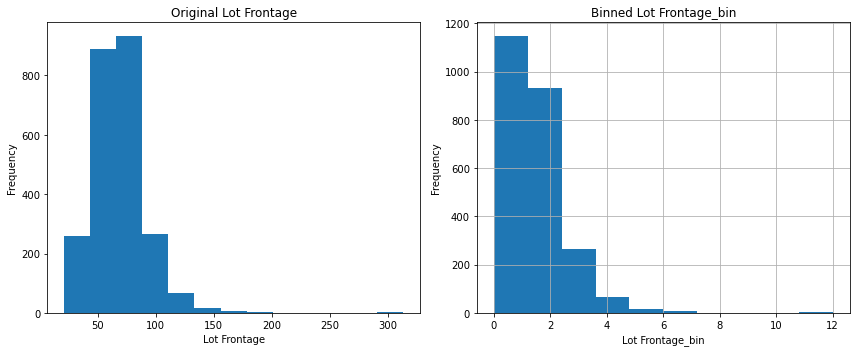

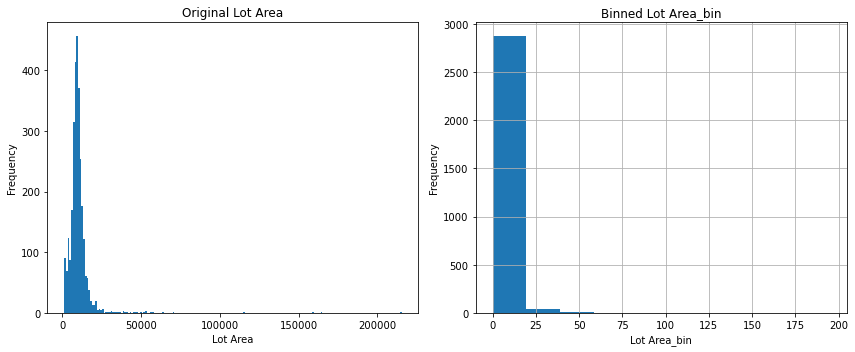

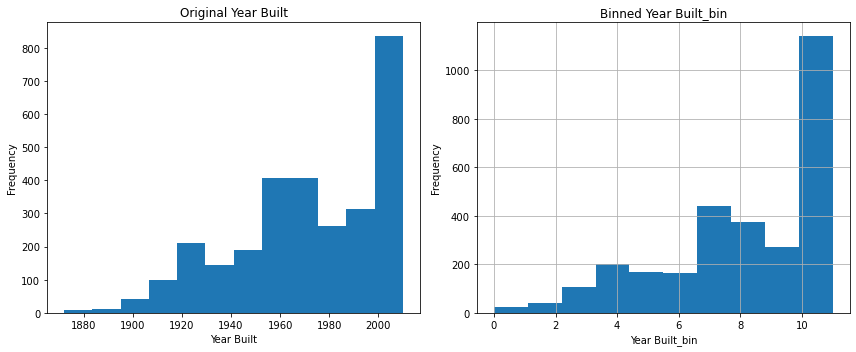

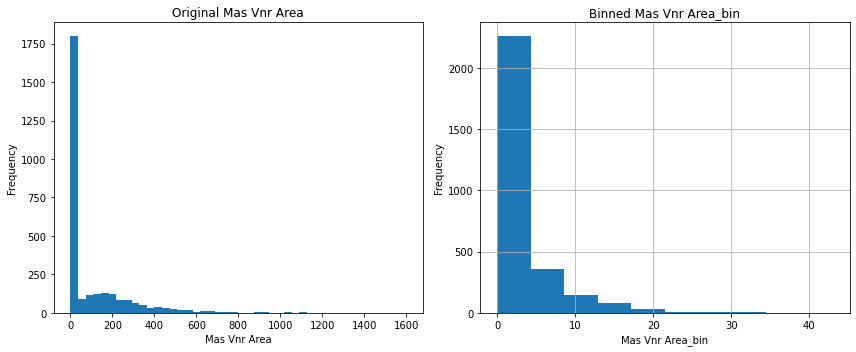

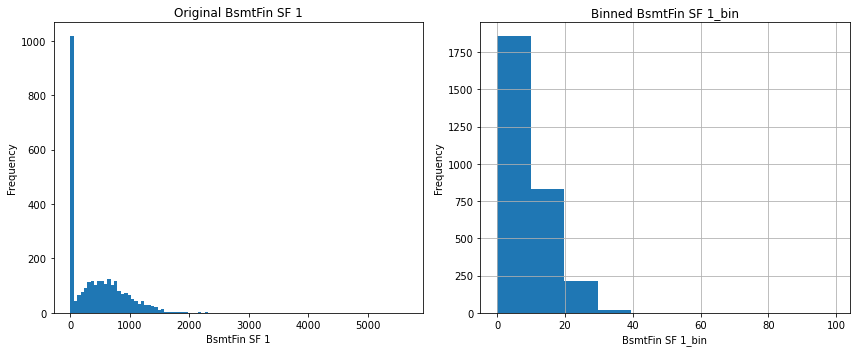

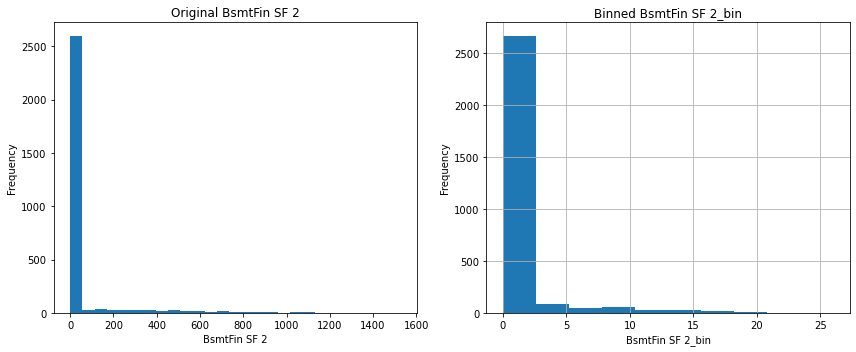

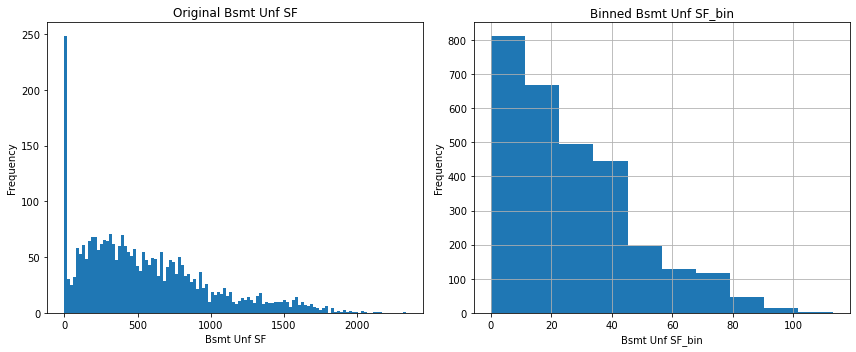

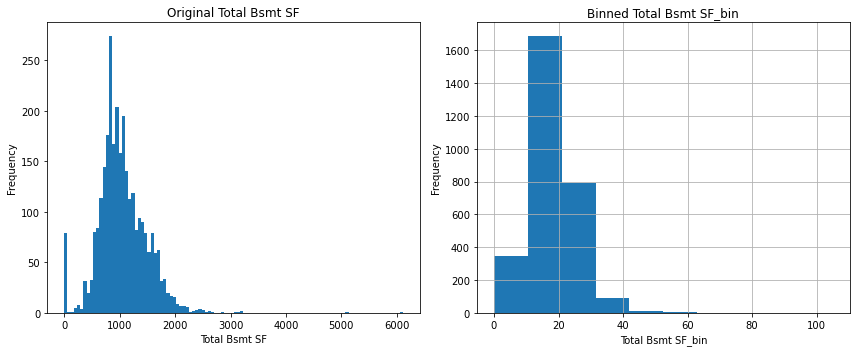

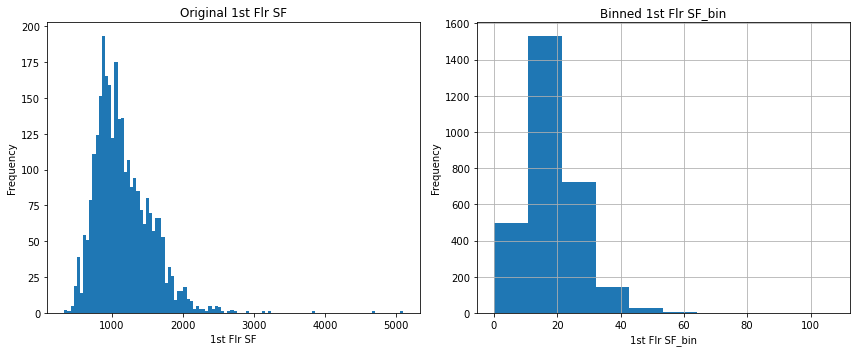

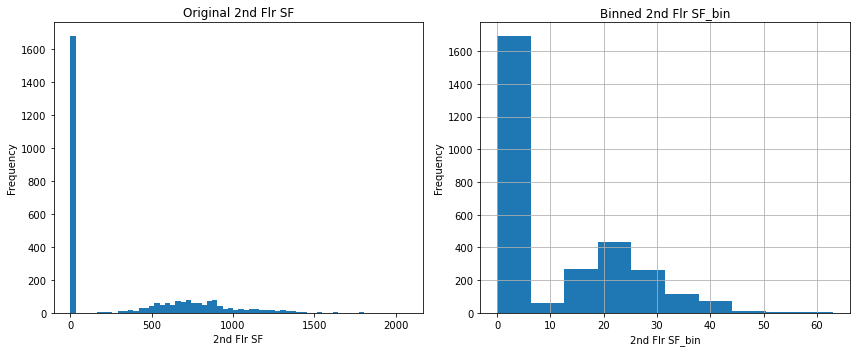

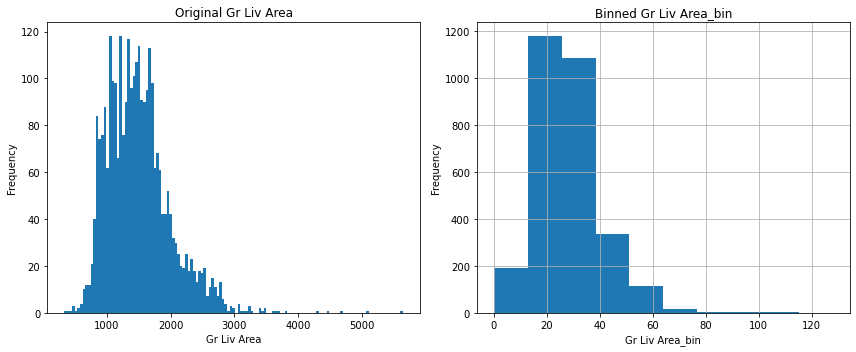

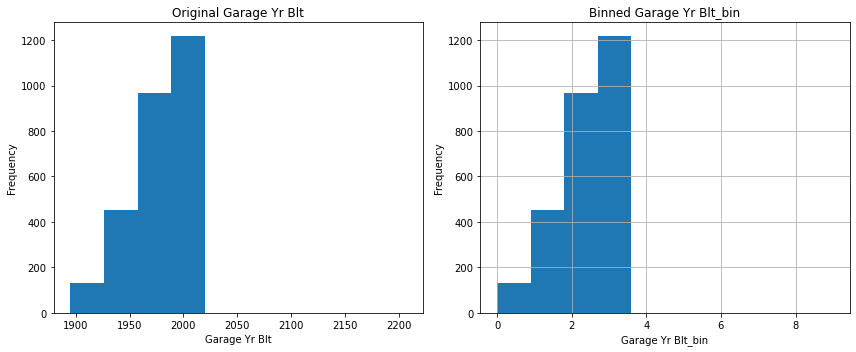

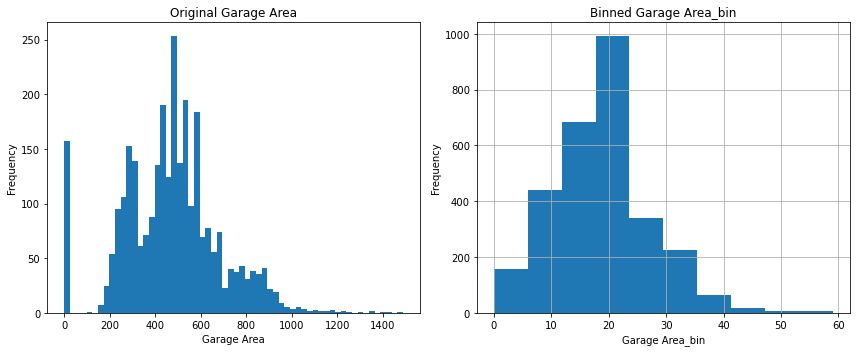

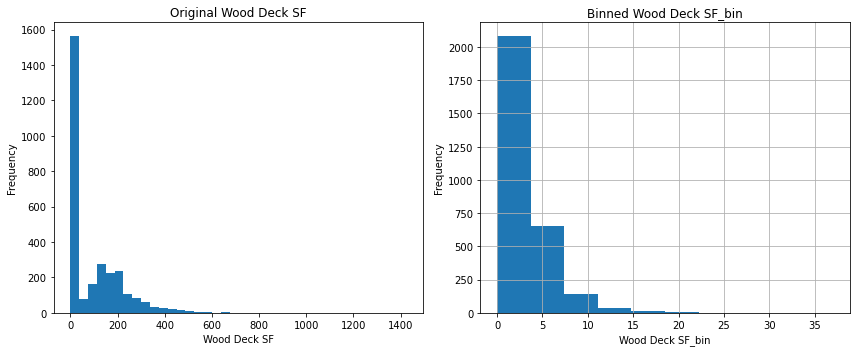

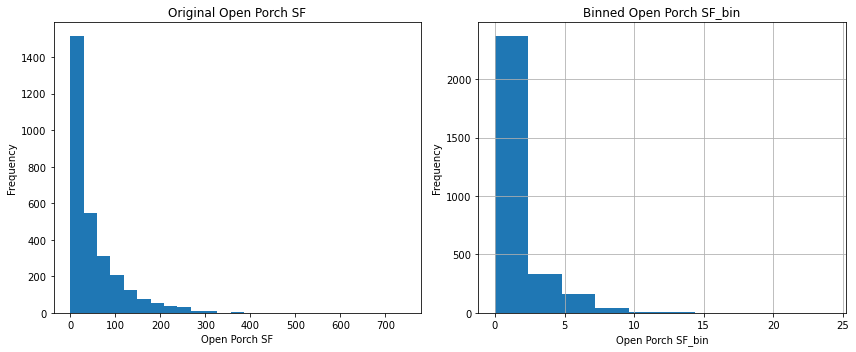

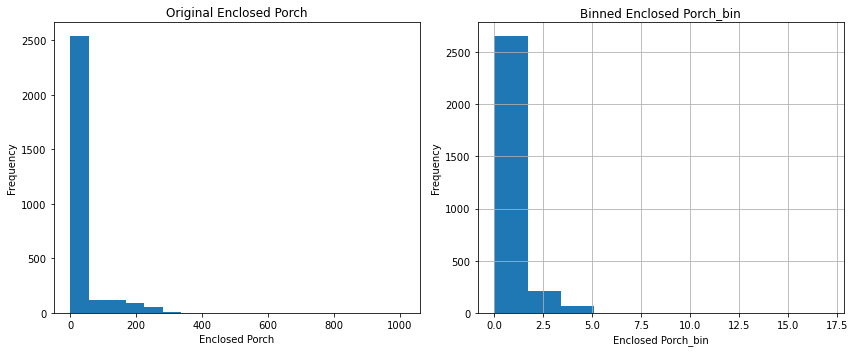

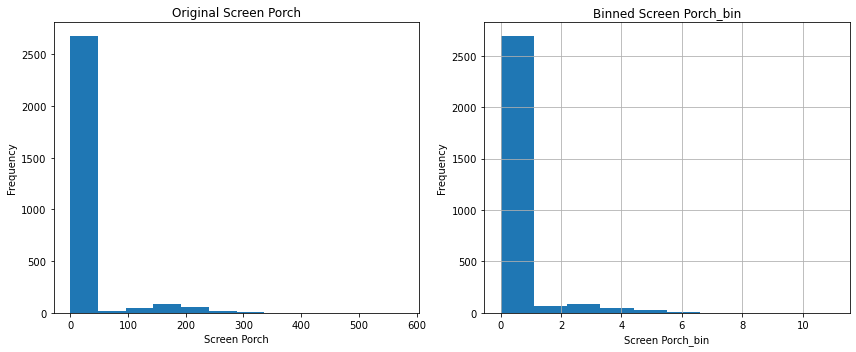

In [6]:
target_col = "SalePrice"
for col in df.columns:
    # Skip the target column and PID
    if col != target_col and col != "PID":
        n_unique = df[col].nunique()
        if n_unique > 100:  # This threshold is arbitrary
            num_bins = round(n_unique / 10)
            bin_col_name = f'{col}_bin'
            df[bin_col_name] = pd.cut(df[col], bins=num_bins, labels=False)

            # Visualization
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))

            # Original column plot
            ax[0].hist(df[col].dropna(), bins=num_bins)  # Using dropna() to avoid issues with NaN values
            ax[0].set_title(f'Original {col}')
            ax[0].set_xlabel(col)
            ax[0].set_ylabel('Frequency')

            # Binned column plot
            df[bin_col_name].hist(ax=ax[1])
            ax[1].set_title(f'Binned {bin_col_name}')
            ax[1].set_xlabel(bin_col_name)
            ax[1].set_ylabel('Frequency')

            plt.tight_layout()
            plt.show()


### Case 1: You need to explain about One-hot encoding (to specify median or mean, it's better to see if we have outliers in corresponding column)

In [7]:
def pre_process(df):
    df = df.drop(['Lot Frontage', 'Alley', 'Fireplace Qu', 'Fence', 'Misc Feature', 'Lot Frontage_bin'], axis=1)
    
    # Fill numeric missing values
    num_df = df.select_dtypes(include='number')
    num_cols = num_df.columns
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    
    # Fill string missing values
    str_df = df.select_dtypes(include='object')
    str_cols = str_df.columns
    for col in str_cols:
        df[col] = df[col].fillna(df[col].value_counts().idxmax())
    
    # One-hot encoding
    df = pd.get_dummies(df, columns=str_cols, drop_first=True)
    
    return df

ptr_df=pre_process(df)
ptr_df.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
Order,,,,,,,,,,,,,,,,,,,,,
1,20,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,...,0,0,0,0,1,0,0,0,1,0
2,20,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,...,0,0,0,0,1,0,0,0,1,0
3,20,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,...,0,0,0,0,1,0,0,0,1,0
4,20,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,...,0,0,0,0,1,0,0,0,1,0
5,60,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,...,0,0,0,0,1,0,0,0,1,0


### Case 2: You need to explain Encoding (encoding vs one-hot encoding)to specify median or mean, it's better to see if we have outliers in corresponding column

In [8]:
def pre_process(df):
    df = df.drop(['Lot Frontage', 'Alley', 'Fireplace Qu', 'Fence', 'Misc Feature', 'Lot Frontage_bin'], axis=1)
    
    # Fill numeric missing values
    num_df = df.select_dtypes(include='number')
    num_cols = num_df.columns
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    
    # Fill string missing values
    str_df = df.select_dtypes(include='object')
    str_cols = str_df.columns
    for col in str_cols:
        df[col] = df[col].fillna(df[col].value_counts().idxmax())
    
    # Encoding string columns
    for col in str_cols:
        df[col] = pd.factorize(df[col])[0]
    
    return df

ptrV2_df=pre_process(df)
ptrV2_df.head()

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Total Bsmt SF_bin,1st Flr SF_bin,2nd Flr SF_bin,Gr Liv Area_bin,Garage Yr Blt_bin,Garage Area_bin,Wood Deck SF_bin,Open Porch SF_bin,Enclosed Porch_bin,Screen Porch_bin
Order,,,,,,,,,,,,,,,,,,,,,
1,20,0,31770,0,0,0,0,0,0,0,...,18.0,29,0,32,2.0,21.0,5,2,0,0
2,20,1,11622,0,1,0,0,1,0,0,...,15.0,12,0,13,2.0,29.0,3,0,0,2
3,20,0,14267,0,0,0,0,0,0,0,...,23.0,22,0,24,2.0,12.0,10,1,0,0
4,20,0,11160,0,1,0,0,0,0,0,...,36.0,40,0,43,2.0,21.0,0,0,0,0
5,60,0,13830,0,0,0,0,1,0,1,...,16.0,13,21,31,3.0,19.0,5,1,0,0


### Finding outliers

In [9]:
z_scores = zscore(ptrV2_df.select_dtypes(include=[float, int])) # Compute z-scores only for numeric columns
abs_z_scores = abs(z_scores)

# Threshold is typically 3 for z-scores but you can adjust based on your needs
outliers = (abs_z_scores > 3).all(axis=1)
df_clean = ptrV2_df[~outliers]

print(f"Number of outliers detected: {sum(outliers)}")
print(f"Data shape after outlier removal: {df_clean.shape}")

Number of outliers detected: 0
Data shape after outlier removal: (2930, 91)


In [10]:
ptrV2_df.head()

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Total Bsmt SF_bin,1st Flr SF_bin,2nd Flr SF_bin,Gr Liv Area_bin,Garage Yr Blt_bin,Garage Area_bin,Wood Deck SF_bin,Open Porch SF_bin,Enclosed Porch_bin,Screen Porch_bin
Order,,,,,,,,,,,,,,,,,,,,,
1,20,0,31770,0,0,0,0,0,0,0,...,18.0,29,0,32,2.0,21.0,5,2,0,0
2,20,1,11622,0,1,0,0,1,0,0,...,15.0,12,0,13,2.0,29.0,3,0,0,2
3,20,0,14267,0,0,0,0,0,0,0,...,23.0,22,0,24,2.0,12.0,10,1,0,0
4,20,0,11160,0,1,0,0,0,0,0,...,36.0,40,0,43,2.0,21.0,0,0,0,0
5,60,0,13830,0,0,0,0,1,0,1,...,16.0,13,21,31,3.0,19.0,5,1,0,0


In [11]:
# Instantiate the scaler
scaler = MinMaxScaler()

# Fit the scaler on your data & then transform
df_normalized = scaler.fit_transform(ptrV2_df.select_dtypes(include=['float64', 'int64']))

# Convert the array back to a dataframe
df_normalized = pd.DataFrame(df_normalized, columns=ptrV2_df.select_dtypes(include=['float64', 'int64']).columns)

print(df_normalized.head())

   MS SubClass  MS Zoning  Lot Area  Street  Lot Shape  Land Contour  \
0     0.000000   0.000000  0.142420     0.0   0.000000           0.0   
1     0.000000   0.166667  0.048246     0.0   0.333333           0.0   
2     0.000000   0.000000  0.060609     0.0   0.000000           0.0   
3     0.000000   0.000000  0.046087     0.0   0.333333           0.0   
4     0.235294   0.000000  0.058566     0.0   0.000000           0.0   

   Utilities  Lot Config  Land Slope  Neighborhood  ...  Total Bsmt SF_bin  \
0        0.0        0.00         0.0      0.000000  ...           0.171429   
1        0.0        0.25         0.0      0.000000  ...           0.142857   
2        0.0        0.00         0.0      0.000000  ...           0.219048   
3        0.0        0.00         0.0      0.000000  ...           0.342857   
4        0.0        0.25         0.0      0.037037  ...           0.152381   

   1st Flr SF_bin  2nd Flr SF_bin  Gr Liv Area_bin  Garage Yr Blt_bin  \
0        0.271028        

### Feature Selection

#### Correlation analysis:  When features are highly correlated with each other, they may not provide unique information to the model. This multicollinearity can lead to unstable estimates in some regression models.

In [12]:
correlation_matrix = df_normalized.corr()
# Identify Highly Correlated Features
threshold = 0.8  # You can adjust this threshold value as per your criteria
highly_correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_pairs.append((colname_i, colname_j))

print(highly_correlated_pairs)

[('1st Flr SF', 'Total Bsmt SF'), ('TotRms AbvGrd', 'Gr Liv Area'), ('Garage Area', 'Garage Cars'), ('Lot Area_bin', 'Lot Area'), ('Year Built_bin', 'Year Built'), ('Mas Vnr Area_bin', 'Mas Vnr Area'), ('BsmtFin SF 1_bin', 'BsmtFin SF 1'), ('BsmtFin SF 2_bin', 'BsmtFin SF 2'), ('Bsmt Unf SF_bin', 'Bsmt Unf SF'), ('Total Bsmt SF_bin', 'Total Bsmt SF'), ('Total Bsmt SF_bin', '1st Flr SF'), ('1st Flr SF_bin', '1st Flr SF'), ('1st Flr SF_bin', 'Total Bsmt SF_bin'), ('2nd Flr SF_bin', '2nd Flr SF'), ('Gr Liv Area_bin', 'Gr Liv Area'), ('Gr Liv Area_bin', 'TotRms AbvGrd'), ('Garage Yr Blt_bin', 'Garage Yr Blt'), ('Garage Area_bin', 'Garage Cars'), ('Garage Area_bin', 'Garage Area'), ('Wood Deck SF_bin', 'Wood Deck SF'), ('Open Porch SF_bin', 'Open Porch SF'), ('Enclosed Porch_bin', 'Enclosed Porch'), ('Screen Porch_bin', 'Screen Porch')]


In [13]:
# To ensure that X doesn't have any non-numeric columns
non_numeric_cols = df_normalized.select_dtypes(exclude=['int64', 'float64']).columns
print(non_numeric_cols)

Index([], dtype='object')


In [14]:
# Handling missing values is crucial because most machine learning algorithms can't handle them directly.
missing_values = df_normalized.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [15]:
# Assuming 'SalePrice' is the column you're trying to predict
y = df_normalized['SalePrice']

# Drop the 'SalePrice' column to create the features matrix X
X = df_normalized.drop('SalePrice', axis=1)


In [16]:
X.head()

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Total Bsmt SF_bin,1st Flr SF_bin,2nd Flr SF_bin,Gr Liv Area_bin,Garage Yr Blt_bin,Garage Area_bin,Wood Deck SF_bin,Open Porch SF_bin,Enclosed Porch_bin,Screen Porch_bin
0,0.000000,0.000000,0.142420,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,...,0.171429,0.271028,0.000000,0.250000,0.222222,0.355932,0.135135,0.083333,0.0,0.000000
1,0.000000,0.166667,0.048246,0.0,0.333333,0.0,0.0,0.25,0.0,0.000000,...,0.142857,0.112150,0.000000,0.101562,0.222222,0.491525,0.081081,0.000000,0.0,0.181818
2,0.000000,0.000000,0.060609,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,...,0.219048,0.205607,0.000000,0.187500,0.222222,0.203390,0.270270,0.041667,0.0,0.000000
3,0.000000,0.000000,0.046087,0.0,0.333333,0.0,0.0,0.00,0.0,0.000000,...,0.342857,0.373832,0.000000,0.335938,0.222222,0.355932,0.000000,0.000000,0.0,0.000000
4,0.235294,0.000000,0.058566,0.0,0.000000,0.0,0.0,0.25,0.0,0.037037,...,0.152381,0.121495,0.333333,0.242188,0.333333,0.322034,0.135135,0.041667,0.0,0.000000


### Random Forest for Feature Importance

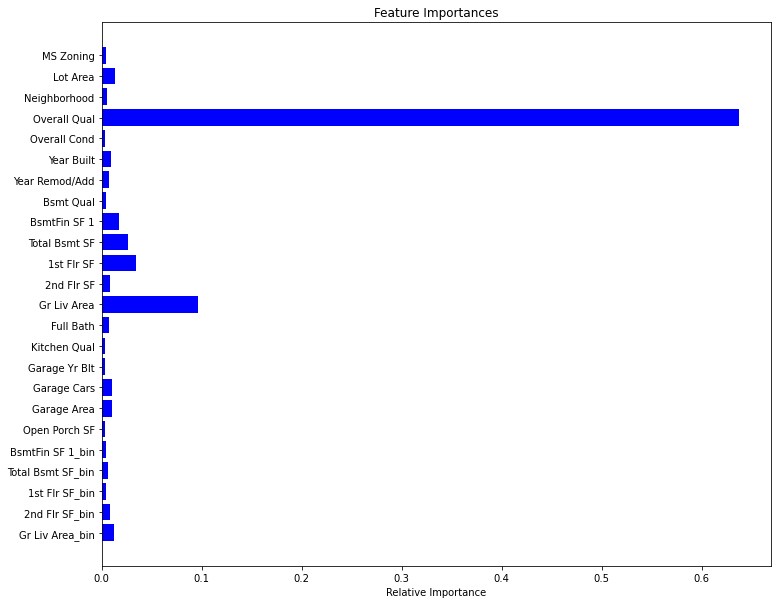

In [17]:
# Assuming X and y are already defined
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)

# Get feature importance
feature_importances = rf.feature_importances_
feature_names = X.columns
# Step 3: Identify features with importance above the threshold
threshold = 0.003
cols_to_keep_indices = np.where(feature_importances > threshold)[0]
cols_to_keep_importances = feature_importances[cols_to_keep_indices]
cols_to_keep_names = [feature_names[i] for i in cols_to_keep_indices]

# Visualization
plt.figure(figsize=(12, 10))
plt.title('Feature Importances')
plt.barh(cols_to_keep_names, cols_to_keep_importances, color='b', align='center')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Relative Importance')
plt.show()



Mean Squared Error: 0.002383238160074973


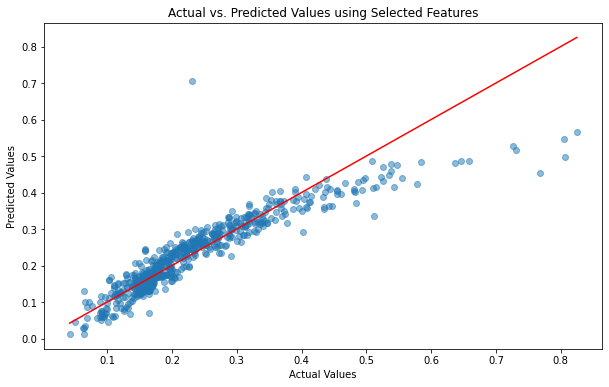

In [18]:
# Using only the selected features from feature importance for X
X_selected = X[cols_to_keep_names]
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create and train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict the outputs
y_pred = lr.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values using Selected Features")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # a diagonal red line for reference
plt.show()

### Model Interpretation

#### The change in the dependent variable for a one-unit change in the predictor variable. Note that the magnitude of the coefficients can be influenced by the scale of the features, so it's crucial to ensure all the features are on the same scale before interpreting them.

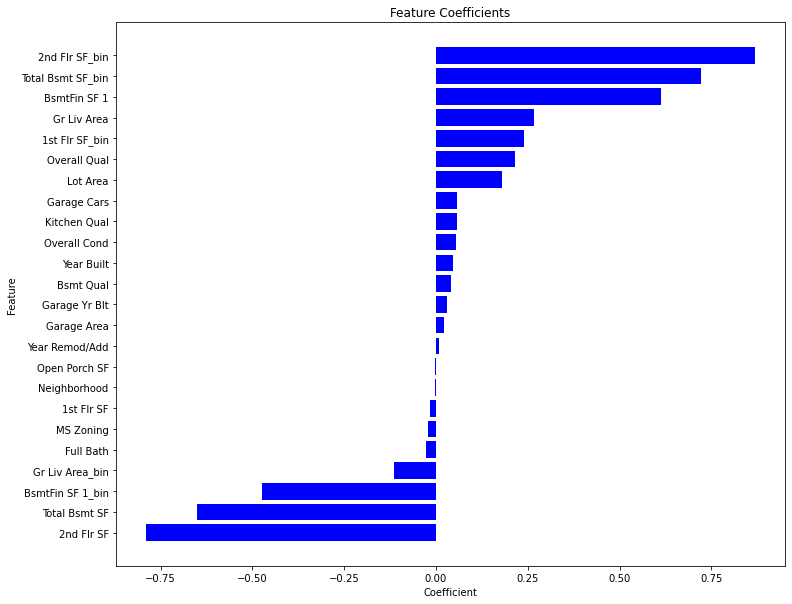

In [19]:
# Get the coefficients
coefficients = lr.coef_

# Create a dataframe for coefficients
coef_df = pd.DataFrame({
    'Feature': cols_to_keep_names,
    'Coefficient': coefficients
})

# Sort the features based on coefficient magnitude
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Visualization
plt.figure(figsize=(12, 10))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='b')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients')
plt.gca().invert_yaxis()  # Highest coefficients at the top
plt.show()

## Random Forest Regressor an alternative model 

Mean Squared Error using Random Forest Regressor: 0.0013571994041218429


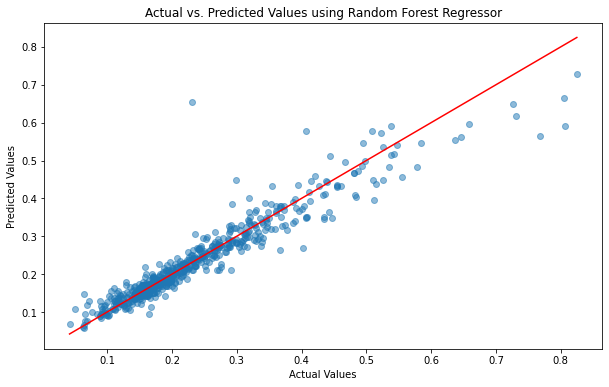

In [20]:
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_regressor.predict(X_test)

# Calculate the Mean Squared Error
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error using Random Forest Regressor: {mse_rf}")

# Visualization of Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values using Random Forest Regressor")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # a diagonal red line for reference
plt.show()

#### Partial Dependence Plots (PDP): It visualizes the marginal effect of a variable on the predicted outcome.

C:\Users\mohaa\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


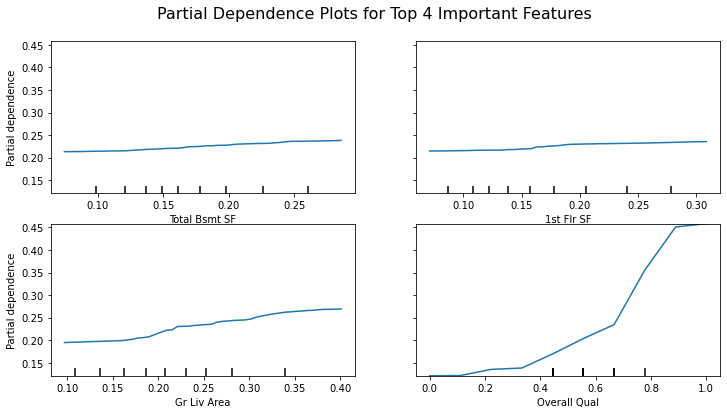

In [21]:
important_indices = np.argsort(rf_regressor.feature_importances_)[-4:]

# Compute and plot PDPs for the four most important features
fig, ax = plt.subplots(figsize=(12, 6))
plot_partial_dependence(rf_regressor, X_train, important_indices, grid_resolution=50, ax=ax, n_cols=2)
plt.suptitle('Partial Dependence Plots for Top 4 Important Features', fontsize=16)
plt.subplots_adjust(top=0.9)  # Adjust title position
plt.show()

#### Out of the four features examined, "Overall Qual" has the most pronounced impact on the house's predicted price. High-quality homes are valued significantly higher.

## Gradient Boosting Regressor an alternative model 

Mean Squared Error: 0.001336250767163255


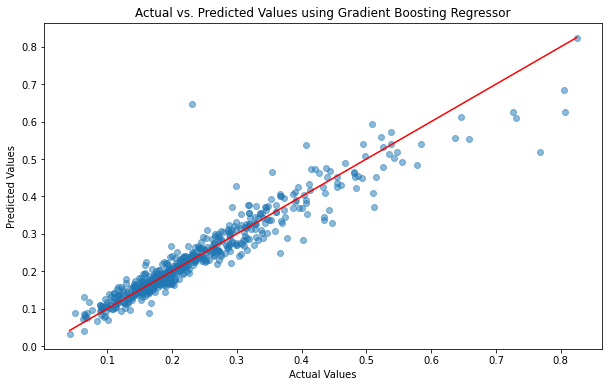

In [22]:
# Create and train the model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

# Predict the outputs
y_pred = gbr.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values using Gradient Boosting Regressor")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # a diagonal red line for reference
plt.show()

#### Partial Dependence Plots (PDP): It visualizes the marginal effect of a variable on the predicted outcome.

C:\Users\mohaa\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


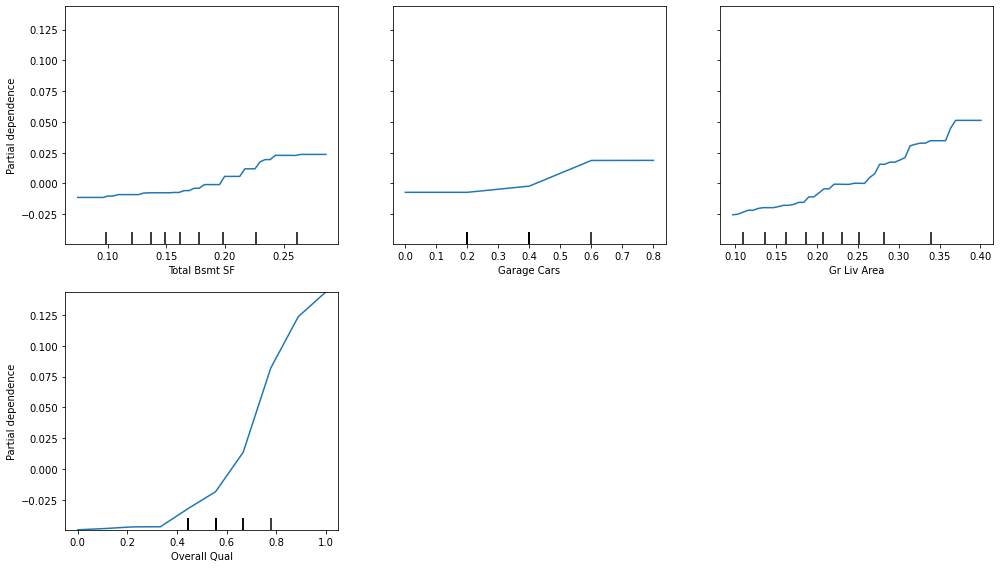

In [23]:
# Get top 4 features from the model (you can choose any other method for feature selection)
top_features = np.argsort(gbr.feature_importances_)[-4:]

# Create PDP plots for the top features
fig, ax = plt.subplots(figsize=(14, 8))
plot_partial_dependence(gbr, X_train, features=top_features, grid_resolution=50, ax=ax, n_jobs=-1)
plt.tight_layout()
plt.show()